In [1]:
import argparse, collections, sys, requests, socket, torch, mlflow, mlflow.pytorch, random, copy
import json
import numpy as np
import data_loader.data_loaders as module_data
import loss as module_loss
import model.metric as module_metric
import model.model as module_arch

from tqdm import tqdm
from parse_config import ConfigParser
from trainer import DefaultTrainer, TruncatedTrainer, GroundTruthTrainer
from collections import OrderedDict
from trainer.svd_classifier import iterative_eigen, get_out_list, get_singular_value_vector, get_loss_list, isNoisy_ratio

/home/jongwooko/anaconda3/lib/python3.7/site-packages/wandb/util.py:37: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import namedtuple, Mapping, Sequence
/home/jongwooko/anaconda3/lib/python3.7/site-packages/wandb/vendor/graphql-core-1.1/graphql/type/directives.py:55: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  assert isinstance(locations, collections.Iterable), 'Must provide locations for directive.'


In [2]:
config_file = './hyperparams/multistep/config_cifar10_elr_rn34.json'
with open(config_file, 'r') as f:
    config = json.load(f)
    
resume_path = './checkpoint/multistep_sym_60_elr.pth'
base_model = getattr(module_arch, config['arch']['type'])()
checkpoint = torch.load(resume_path)
state_dict = checkpoint['state_dict']
base_model.load_state_dict(state_dict)

<All keys matched successfully>

In [3]:
config['trainer']['percent'] = 0.6
config['trainer']['asym'] = False

In [4]:
config

{'name': 'cifar10_resnet34_multistep',
 'n_gpu': 1,
 'seed': 123,
 'arch': {'type': 'resnet34', 'args': {'num_classes': 10}},
 'num_classes': 10,
 'data_loader': {'type': 'CIFAR10DataLoader',
  'args': {'data_dir': './dir_to_data',
   'batch_size': 128,
   'shuffle': True,
   'num_batches': 0,
   'validation_split': 0,
   'num_workers': 8,
   'pin_memory': True}},
 'optimizer': {'type': 'SGD',
  'args': {'lr': 0.02, 'momentum': 0.9, 'weight_decay': 0.001}},
 'train_loss': {'type': 'ELRLoss', 'args': {'beta': 0.7, 'lambda': 3}},
 'val_loss': 'CrossEntropyLoss',
 'metrics': ['my_metric', 'my_metric2'],
 'lr_scheduler': {'type': 'MultiStepLR',
  'args': {'milestones': [40, 80], 'gamma': 0.01}},
 'trainer': {'epochs': 120,
  'warmup': 0,
  'save_dir': 'saved/',
  'save_period': 1,
  'verbosity': 2,
  'label_dir': 'saved/',
  'monitor': 'max test_my_metric',
  'early_stop': 2000,
  'tensorboard': False,
  'mlflow': True,
  '_percent': 'Percentage of noise',
  'percent': 0.6,
  '_begin': 'Wh

In [5]:
# set seed
random.seed(config['seed'])
torch.manual_seed(config['seed'])
torch.cuda.manual_seed_all(config['seed'])
torch.backends.cudnn.deterministic = True
np.random.seed(config['seed'])

data_loader = getattr(module_data, config['data_loader']['type'])(
    config['data_loader']['args']['data_dir'],
    batch_size= 100,
    shuffle=config['data_loader']['args']['shuffle'],
    validation_split=0.0,
    num_batches=config['data_loader']['args']['num_batches'],
    training=True,
    num_workers=config['data_loader']['args']['num_workers'],
    pin_memory=config['data_loader']['args']['pin_memory'],
    config=config
    )

# criterion = getattr(module_loss, 'CCELoss')()
device = torch.device('cuda:0')

Files already downloaded and verified
Train: 50000 Val: 0


In [6]:
data_loader

In [7]:
def get_true_list(model, data_loader):
    
    label_list = np.empty((0, ))
    label_gt_list = np.empty((0, ))
    
    model.eval()
    model.cuda()
    
    with tqdm(data_loader) as progress:
        for batch_idx, (data, label, index, label_gt) in enumerate(progress):
            data = data.cuda()
            label, label_gt = label.long().cuda(), label_gt.long().cuda()
            output, _ = model(data)
            
            label_list = np.concatenate((label_list, label.cpu()))
            label_gt_list = np.concatenate((label_gt_list, label.cpu()))
            
            if batch_idx == 0:
                out_list = output.detach().cpu()
            else:
                out_list = np.concatenate((out_list, output.detach().cpu()), axis=0)
                
    return label_list, label_gt_list, out_list

In [8]:
def get_singular_value_vector(label_list, out_list):
    
    singular_dict = {}
    v_ortho_dict = {}
    
    for index in np.unique(label_list):
        u, s, v = np.linalg.svd(out_list[label_list==index])
        singular_dict[index] = s[0] / s[1]
        v_ortho_dict[index] = torch.from_numpy(v[:2])
        
    return singular_dict, v_ortho_dict

In [9]:
label_list, gt_list, out_list = get_true_list(base_model, data_loader)

100%|██████████| 500/500 [00:17<00:00, 29.30it/s]


In [10]:
singular_dict, v_ortho_dict = get_singular_value_vector(gt_list, out_list)

In [11]:
def cos_similarity_matrix(v_dict):
    
    keys = v_dict.keys()
    first_eigens = []
    matrix = [[] for i in range(10)]
    
    for key in keys:
        first_eigens.append(v_dict[key][0].tolist())
        
    first_eigens = np.array(first_eigens)
    
    for i, v_i in enumerate(first_eigens):
        for v_j in first_eigens:
            matrix[i].append(np.dot(v_i, v_j))
    
    return np.array(matrix)

In [19]:
theta = np.sqrt(1 - np.clip(np.power(cos_similarity_matrix(v_ortho_dict), 2), 0, 1))

theta = np.arcsin(theta) / np.pi * 180.
sine_theta = np.cos(theta * np.pi / 180)
print (theta)

[[8.62843036e-03 6.98896228e+01 6.70818592e+01 7.03277132e+01
  6.87716111e+01 6.89416472e+01 7.02721957e+01 6.98803572e+01
  6.79774748e+01 6.89485898e+01]
 [6.98896228e+01 0.00000000e+00 7.13673403e+01 7.22733915e+01
  7.08057942e+01 7.20062754e+01 7.24175430e+01 7.00021068e+01
  7.03611148e+01 7.03322470e+01]
 [6.70818592e+01 7.13673403e+01 7.42182882e-03 6.88491018e+01
  6.85229352e+01 6.95020624e+01 6.95084494e+01 7.01315283e+01
  6.93493553e+01 6.97641352e+01]
 [7.03277132e+01 7.22733915e+01 6.88491018e+01 0.00000000e+00
  7.11184947e+01 6.75644309e+01 7.15721746e+01 7.25227794e+01
  7.18661698e+01 7.14252826e+01]
 [6.87716111e+01 7.08057942e+01 6.85229352e+01 7.11184947e+01
  6.49573940e-03 7.29721939e+01 7.15404048e+01 7.14192778e+01
  7.09912429e+01 6.99450875e+01]
 [6.89416472e+01 7.20062754e+01 6.95020624e+01 6.75644309e+01
  7.29721939e+01 3.67585618e-03 7.46014681e+01 7.07740359e+01
  7.05852960e+01 7.15290714e+01]
 [7.02721957e+01 7.24175430e+01 6.95084494e+01 7.15721746e

In [13]:
def plot_confusion_matrix(cm, target_names=None, cmap=None, normalize=True, labels=True, title='Confusion matrix'):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
    plt.colorbar()

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    
    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names)
        plt.yticks(tick_marks, target_names)
    
#     if labels:
#         for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
#             if normalize:
#                 plt.text(j, i, "{:0.4f}".format(cm[i, j]),
#                          horizontalalignment="center",
#                          color="white" if cm[i, j] > thresh else "black")
#             else:
#                 plt.text(j, i, "{:,}".format(cm[i, j]),
#                          horizontalalignment="center",
#                          color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
#     plt.ylabel('True label')
#     plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

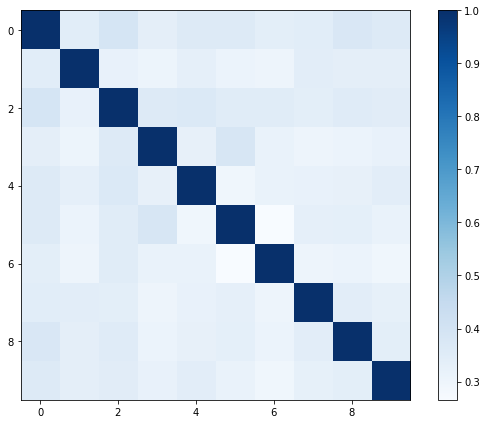

In [14]:
import matplotlib.pyplot as plt
import itertools
plot_confusion_matrix(sine_theta, normalize=False)

In [15]:
# array([[1.        , 0.73375449, 0.84362395, 0.79943598, 0.81097123,
#         0.77656694, 0.80455549, 0.81613805, 0.85543287, 0.76411742],
#        [0.73375449, 1.        , 0.70296539, 0.71555271, 0.70013463,
#         0.69328445, 0.70381206, 0.72377065, 0.74303114, 0.74702262],
#        [0.84362395, 0.70296539, 1.        , 0.8688378 , 0.87467734,
#         0.85344589, 0.85514977, 0.85796666, 0.81973085, 0.74694619],
#        [0.79943598, 0.71555271, 0.8688378 , 1.        , 0.88361543,
#         0.97021502, 0.88024957, 0.88904471, 0.83550472, 0.77063328],
#        [0.81097123, 0.70013463, 0.87467734, 0.88361543, 0.99999999,
#         0.85327387, 0.85179379, 0.88839564, 0.81061002, 0.76004186],
#        [0.77656694, 0.69328445, 0.85344589, 0.97021502, 0.85327387,
#         1.        , 0.83399632, 0.87447303, 0.80652521, 0.7674461 ],
#        [0.80455549, 0.70381206, 0.85514977, 0.88024957, 0.85179379,
#         0.83399632, 0.99999999, 0.8369593 , 0.79076266, 0.74363458],
#        [0.81613805, 0.72377065, 0.85796666, 0.88904471, 0.88839564,
#         0.87447303, 0.8369593 , 1.        , 0.804183  , 0.77361728],
#        [0.85543287, 0.74303114, 0.81973085, 0.83550472, 0.81061002,
#         0.80652521, 0.79076266, 0.804183  , 1.        , 0.77273571],
#        [0.76411742, 0.74702262, 0.74694619, 0.77063328, 0.76004186,
#         0.7674461 , 0.74363458, 0.77361728, 0.77273571, 1.        ]])

In [16]:
# def singular_label(v_ortho_dict, model_represents, label):
    
#     model_represents = torch.from_numpy(model_represents).cuda()
#     sing_lbl = torch.zeros(model_represents.shape[0])
#     sin_score_lbl = torch.zeros(model_represents.shape[0])
    
#     for i, data in enumerate(model_represents):
#         sin_score_lbl[i] = torch.dot(v_ortho_dict[label[i]][0], data).abs() - torch.dot(v_ortho_dict[label[i]][1], data).abs()
#         if torch.dot(v_ortho_dict[label[i]][0], data).abs() < torch.dot(v_ortho_dict[label[i]][1], data).abs():
#             sing_lbl[i] = 1
        
#     return sing_lbl, sin_score_lbl

In [17]:
# def iterative_eigen(number, label_list, out_list, teacher_idx=None):
#     sin_lbls = {}
    
#     for i in range(number):
#         tmp_lbl = torch.zeros(50000)
#         if teacher_idx != None:
#             for num in (set(range(0, 50000)) - set(teacher_idx)):
#                 tmp_lbl[num] += 1
#         print (tmp_lbl.sum().)